In [1]:
import zipfile
unzip = False
if unzip:
    with zipfile.ZipFile("Data1.zip","r") as zip_ref:
        zip_ref.extractall("Data1")

In [156]:
person = 'Promi'

In [157]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import scipy

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

In [110]:
# !pip install --upgrade tensorflow keras

In [111]:
# !pip install scipy

In [158]:
def load_data(base_dir, csv_file):
    df = pd.read_csv(csv_file, names=['filename'], header=None)
    df['filename'] = df['filename'].apply(lambda x: os.path.join(base_dir, x))
    return df

In [159]:
base_dir_train = "Data1/Data1/train/"
base_dir_test = "Data1/Data1/test/"

In [160]:
covid_df = load_data(os.path.join(base_dir_train, 'COVID19'), 'covid_split_' + person + '.csv')
normal_df = load_data(os.path.join(base_dir_train, 'NORMAL'), 'normal_split_' + person + '.csv')
pneumonia_df = load_data(os.path.join(base_dir_train, 'PNEUMONIA'), 'PNEUMONIA_split_' + person + '.csv')

In [161]:
covid_df.shape

(147, 1)

In [162]:
normal_df.shape

(398, 1)

In [163]:
pneumonia_df.shape

(1069, 1)

In [164]:
covid_df['label'] = 1
normal_df['label'] = 0
pneumonia_df['label'] = 2
all_images_df = pd.concat([covid_df, normal_df, pneumonia_df])

In [165]:
pd.read_csv('covid_split_' + person + '.csv', names=['filename'], header=None).shape

(147, 1)

In [166]:
pd.read_csv('normal_split_' + person + '.csv', names=['filename'], header=None).shape

(398, 1)

In [167]:
pd.read_csv('PNEUMONIA_split_' + person + '.csv', names=['filename'], header=None).shape

(1069, 1)

In [168]:
covid_df.shape

(147, 2)

In [169]:
all_images_df

,filename,label
0,Data1/Data1/train/COVID19/COVID19(309).jpg,1
1,Data1/Data1/train/COVID19/COVID19(286).jpg,1
2,Data1/Data1/train/COVID19/COVID19(402).jpg,1
3,Data1/Data1/train/COVID19/COVID19(117).jpg,1
4,Data1/Data1/train/COVID19/COVID19(547).jpg,1
...,...,...
1064,Data1/Data1/train/PNEUMONIA/PNEUMONIA(4091).jpg,2
1065,Data1/Data1/train/PNEUMONIA/PNEUMONIA(2846).jpg,2
1066,Data1/Data1/train/PNEUMONIA/PNEUMONIA(1293).jpg,2
1067,Data1/Data1/train/PNEUMONIA/PNEUMONIA(3304).jpg,2


In [170]:
all_images_df.label.value_counts()

label
2    1069
0     398
1     147
Name: count, dtype: int64

In [171]:
shuffled_df = all_images_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [172]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3)


In [173]:
train_generator = datagen.flow_from_dataframe(
    dataframe=shuffled_df,
    x_col='filename',
    y_col='label',
    subset='training',
    batch_size=64,
    seed=30144,
    shuffle=True,
    class_mode='raw',
    target_size=(224, 224))

Found 908 validated image filenames.


/mnt/cgreski/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 317 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [174]:
Counter(train_generator.labels)

Counter({2: 603, 0: 215, 1: 90})

In [175]:
validation_generator = datagen.flow_from_dataframe(
    dataframe=shuffled_df,
    x_col='filename',
    y_col='label',
    subset='validation',
    batch_size=64,
    seed=30144,
    shuffle=True,
    class_mode='raw',
    target_size=(224, 224))

Found 389 validated image filenames.


In [176]:
Counter(validation_generator.labels)

Counter({2: 247, 0: 110, 1: 32})

In [247]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [254]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [257]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

In [180]:
model = Model(inputs=base_model.input, outputs=predictions)

In [181]:
for layer in base_model.layers:
    layer.trainable = False

In [182]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [183]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10


/mnt/cgreski/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.6026 - loss: 0.8954 - val_accuracy: 0.8946 - val_loss: 0.2842
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9148 - loss: 0.2411 - val_accuracy: 0.9152 - val_loss: 0.2217
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9366 - loss: 0.1583 - val_accuracy: 0.9203 - val_loss: 0.2257
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9418 - loss: 0.1345 - val_accuracy: 0.9332 - val_loss: 0.1912
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9607 - loss: 0.1235 - val_accuracy: 0.9383 - val_loss: 0.1638
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9689 - loss: 0.0983 - val_accuracy: 0.9383 - val_loss: 0.1721
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9680 - loss: 0.0988 - val_accuracy: 0.9306 - val_loss: 0.1775
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9752 - loss: 0.0905 - val_accuracy: 0.9460 - val_loss: 0.1572
Epo

## Testing

In [184]:
def load_test_data(base_dir, csv_file):
    df = pd.read_csv(csv_file, names=['filename'], header=None)
    df['filename'] = df['filename'].apply(lambda x: os.path.join(base_dir, x))
    return df

In [205]:
covid_df_test = load_data(os.path.join(base_dir_test, 'COVID19'), 'COVID19_files.csv')
normal_df_test = load_data(os.path.join(base_dir_test, 'NORMAL'), 'NORMAL_files.csv')
pneumonia_df_test = load_data(os.path.join(base_dir_test, 'PNEUMONIA'), 'PNEUMONIA_files.csv')

# covid_df_test = load_data(os.path.join(base_dir_test, 'COVID19'), 'covid_split_' + person + '.csv')
# normal_df_test = load_data(os.path.join(base_dir_test, 'NORMAL'), 'normal_split_' + person + '.csv')
# pneumonia_df_test = load_data(os.path.join(base_dir_test, 'PNEUMONIA'), 'PNEUMONIA_split_' + person + '.csv')

In [206]:
covid_df_test.shape

(116, 1)

In [207]:
normal_df_test.shape

(317, 1)

In [208]:
pneumonia_df_test.shape

(855, 1)

In [209]:
covid_df_test['label'] = 1
normal_df_test['label'] = 0
pneumonia_df_test['label'] = 2

In [210]:
pneumonia_df_test.shape

(855, 2)

In [211]:
normal_df_test.shape

(317, 2)

In [212]:
covid_df_test.shape

(116, 2)

In [213]:
test_images = pd.concat([covid_df_test, normal_df_test, pneumonia_df_test])

In [214]:
test_images.shape

(1288, 2)

In [215]:
test_images.head()

,filename,label
0,Data1/Data1/test/COVID19/COVID19(470).jpg,1
1,Data1/Data1/test/COVID19/COVID19(535).jpg,1
2,Data1/Data1/test/COVID19/COVID19(562).jpg,1
3,Data1/Data1/test/COVID19/COVID19(574).jpg,1
4,Data1/Data1/test/COVID19/COVID19(466).jpg,1


In [216]:
test_images['label'].value_counts()

label
2    855
0    317
1    116
Name: count, dtype: int64

In [217]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [218]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_images,
    x_col='filename',
    y_col='label',
    batch_size=64,
    seed=30144,
    shuffle=False,
    class_mode='raw',
    target_size=(224, 224))

Found 1288 validated image filenames.


In [219]:
Counter(test_generator.labels)

Counter({2: 855, 0: 317, 1: 116})

In [238]:
results = cmodel.evaluate(test_generator)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9544 - loss: 0.1266
Test Loss: 0.13496747612953186, Test Accuracy: 0.9510869383811951


In [201]:
model.save(person+'_model1.h5')

In [251]:
import tensorflow as tf
kmodel = tf.keras.models.load_model('Kausar_model1.h5')
pmodel = tf.keras.models.load_model('Promi_model1.h5')
amodel = tf.keras.models.load_model('Abhiram_model1.h5')
cmodel = tf.keras.models.load_model('Caleb_model.h5')

In [252]:
kweights = kmodel.get_weights()
pweights = pmodel.get_weights()
aweights = amodel.get_weights()
cweights = cmodel.get_weights()

In [23]:
# kweights

In [37]:
# cweights

In [253]:
global_weights = [sum(x)/4 for x in zip(kweights, cweights, aweights, pweights)]

In [266]:
global_model = Model(inputs=base_model.input, outputs=predictions)

In [267]:
global_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [268]:
global_model.set_weights(global_weights)

In [269]:
results = global_model.evaluate(test_generator)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6412 - loss: 0.7175
Test Loss: 0.5449909567832947, Test Accuracy: 0.774068295955658


In [47]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 45.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 KB 40.3 MB/s eta 0:00:00


In [227]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [152]:
global_model.save('global_model.h5')

In [271]:
true_labels = test_generator.labels

In [272]:
predictions = model.predict(test_generator)
predicted_labels = predictions.argmax(axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


In [118]:
enumerate(true_labels)

In [119]:
predicted_labels

array([2, 2, 2, ..., 2, 2, 2])

In [231]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 28   9 280]
 [  0 114   2]
 [  0   0 855]]


In [232]:
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [233]:
from collections import Counter

Counter(true_labels)

Counter({2: 855, 0: 317, 1: 116})

In [126]:
Counter(predicted_labels)

Counter({2: 1254, 0: 34})

In [273]:
class_report = classification_report(true_labels, predicted_labels, target_names=['Normal', 'COVID', 'Pneumonia'],
    zero_division=0)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.09      0.16       317
       COVID       0.93      0.98      0.95       116
   Pneumonia       0.75      1.00      0.86       855

    accuracy                           0.77      1288
   macro avg       0.89      0.69      0.66      1288
weighted avg       0.83      0.77      0.70      1288



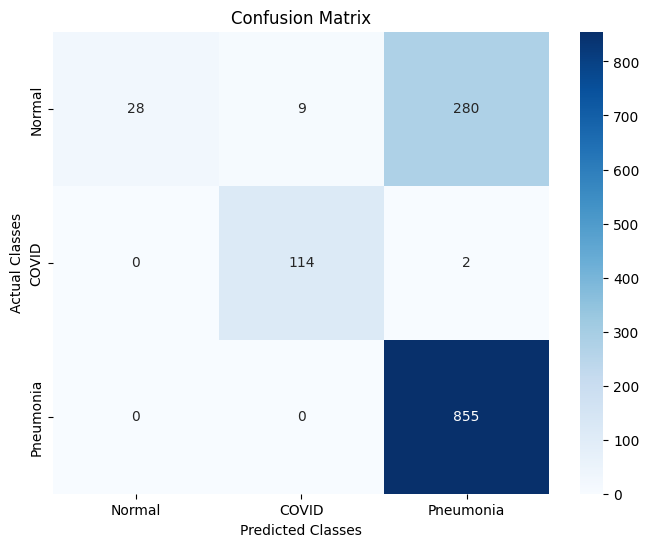

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(true_labels, predicted_labels)


class_labels = ['Normal', 'COVID', 'Pneumonia']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)


plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

plt.show()

In [274]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 3.1 MB/s eta 0:00:00a 0:00:01
